In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score
!pip install shap
import shap

**Load Data**

There are 768 people included in the dataset with 10 columns in the dataset. There is a unique identification number of each person in the dataset and a outcome for the person as either Diabetic or Healthy. The others are potential features: 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness','Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age.'

In [29]:
df=pd.read_csv("/content/drive/MyDrive/assignments/Fall24/Spec/diabetes.csv")
df.insert(0, 'ID', range(0, len(df)))
df.head()
df.astype(int)
df['Outcome'] = np.where(df['Outcome']==0, 'Healthy', 'Diabetic')
print(df.shape)

(768, 10)


In [3]:
df.columns

Index(['ID', 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

**Class Balance**

The data is imbalanced with 35% Diabetic and 65% healthy. This is to be expected with health data and there is usually more health people than unhealthy people. It is not important to understand how this imbalance should be handled moving down stream. Potentially there could be undersampling of the majority class or oversampling of the minorty class.

    Outcome  Relative Frequency (%)
0  Diabetic               34.895833
1   Healthy               65.104167


<ipython-input-30-cab35791dd7a>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ratio_df, x='Outcome', y="Relative Frequency (%)", palette="pastel")


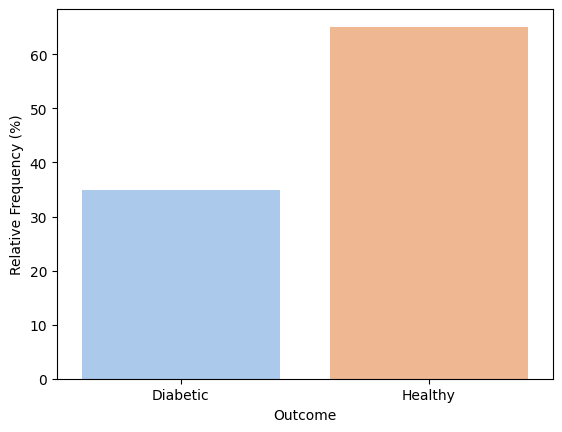

In [30]:
def balanced(df):
  """
    Percentage of people with Diabetes and those without Diabetes
    Balanced or Imbalanced Data

    @p:
      df (dataframe): Input dataframe
  """

  ratio_df=(df[['ID','Outcome']].groupby('Outcome').count()/df.shape[0])*100

  ratio_df.reset_index(inplace=True)

  ratio_df.rename(columns={"ID": "Relative Frequency (%)"}, inplace=True)

  print(ratio_df)

  sns.barplot(data=ratio_df, x='Outcome', y="Relative Frequency (%)", palette="pastel")

  plt.savefig("/content/drive/MyDrive/assignments/Fall24/Spec/output/balanced.png")

balanced(df)

**Conditional Probability**

- Liklihood Someone is has diabetes given they are Overweight (BMI >=25)
- Probability a person is Diabetic Given that she had at least 3 pregnancies

https://www.ramsayhealth.co.uk/weight-loss-surgery/bmi/bmi-for-women

In [10]:
Overweight_and_diabetic_df=df[(df['Outcome']=='Diabetic') & (df['BMI']>=25)]
Overweight_df=df[(df['BMI']>=25)]
prob_diabetic_given_overweight=round((Overweight_and_diabetic_df.shape[0]/Overweight_df.shape[0])*100)
'The probability a person develops Diabetes given she is overweight is {}%'.format(prob_diabetic_given_overweight)

'The probability a person develops Diabetes given she is overweight is 40%'

In [11]:
Preg_and_diabetic_df=df[(df['Outcome']=='Diabetic') & (df['Pregnancies']>=3)]
Preg_df=df[(df['Pregnancies']>=3)]
prob_diabetic_given_preg3=round((Preg_and_diabetic_df.shape[0]/Preg_df.shape[0])*100)
'The probability a person develops Diabetes given she has at least 3 pregnancies is {}%'.format(prob_diabetic_given_preg3)

'The probability a person develops Diabetes given she has at least 3 pregnancies is 43%'

**Distributions**

Histogram plot

,Insulin
count,768.000000
mean,79.799479
std,115.244002
min,0.000000
25%,0.000000
50%,30.500000
75%,127.250000
max,846.000000


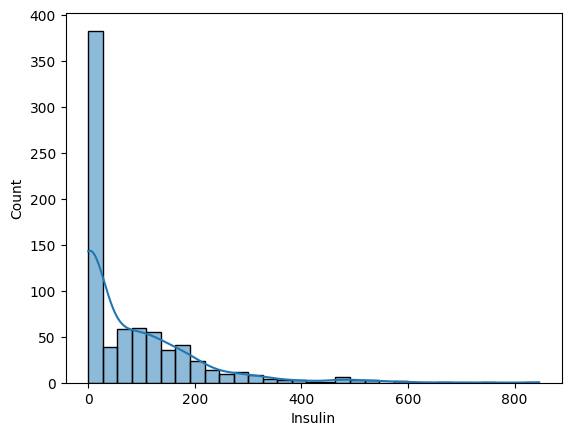

In [12]:
sns.histplot(data=df, x="Insulin",kde=True)
plt.savefig("/content/drive/MyDrive/assignments/Spring24/Spec Project/output/insulin_distribution.png")
df.Insulin.describe()

,Glucose
count,768.000000
mean,120.894531
std,31.972618
min,0.000000
25%,99.000000
50%,117.000000
75%,140.250000
max,199.000000


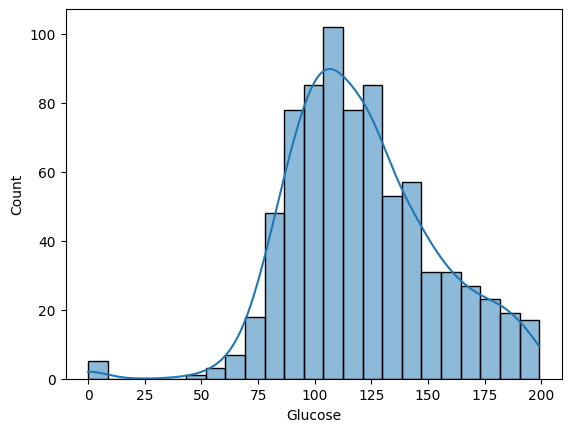

In [13]:
sns.histplot(data=df, x="Glucose",kde=True)
plt.savefig("/content/drive/MyDrive/assignments/Spring24/Spec Project/output/glucose_distribution.png")
df.Glucose.describe()

,SkinThickness
count,768.000000
mean,20.536458
std,15.952218
min,0.000000
25%,0.000000
50%,23.000000
75%,32.000000
max,99.000000


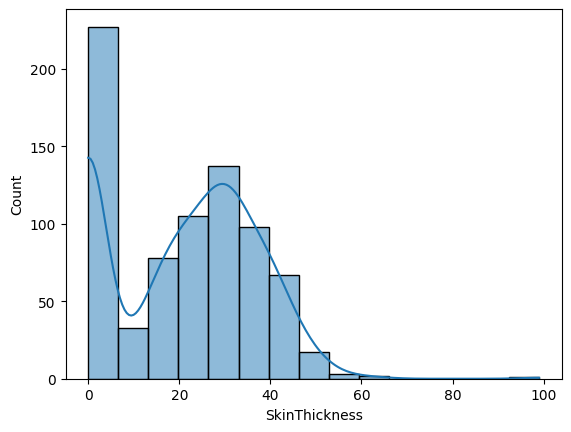

In [14]:
sns.histplot(data=df, x="SkinThickness",kde=True)
plt.savefig("/content/drive/MyDrive/assignments/Spring24/Spec Project/output/SkinThickness_distribution.png")
df.SkinThickness.describe()

**T-Test**

Is the Median/Average Age of a woman who is Diabetic significantly different from the age of a woman who is not Diabetic?

In [15]:

def t_test_survival(df):
  """
    Is the Median/Average Age of a woman who is Diabetic significantly
    different from the age of a woman who is not Diabetic?

    https://www.datacamp.com/tutorial/an-introduction-to-python-t-tests?utm_source=google&utm_medium=paid_search&utm_campaignid=19589720830&utm_adgroupid=143216588377&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=661628555645&utm_targetid=dsa-1947282172981&utm_loc_interest_ms=&utm_loc_physical_ms=9004416&utm_content=dsa~page~community-tuto&utm_campaign=230119_1-sea~dsa~tutorials_2-b2c_3-us_4-prc_5-na_6-na_7-le_8-pdsh-go_9-na_10-na_11-na&gclid=CjwKCAjwivemBhBhEiwAJxNWNyNhPMWI2_jEAUejU7VXHpPFlhbQYhS5W2wSmKHL-KiPZUM-DzKitBoCqS8QAvD_BwE

  """

  df_diab=df[df['Outcome']=='Diabetic']

  df_healthy=df[df['Outcome']=='Healthy']

  N1, N2 = df_diab.shape[0], df_healthy.shape[0]

  # Degrees of freedom
  dof = min(N1,N2) - 1
  print(dof)

  # Gaussian distributed data with mean of fare who died and var = 1
  x = np.random.randn(N1) + df_diab["Age"]

  # Gaussian distributed data with mean of fare who survived and var = 1
  y = np.random.randn(N2) + df_healthy["Age"]

  ## Using the internal function from SciPy Package
  t_stat, p_val = stats.ttest_ind(x, y, equal_var = False)
  print("t-statistic = " + str(t_stat))
  print("p-value = " + str(p_val))

t_test_survival(df)

267
t-statistic = 6.935606291618064
p-value = 1.0906842488370169e-11


In [16]:
diab_age=df[df['Outcome']=='Diabetic']['Age']
diab_age.describe()

,Age
count,268.000000
mean,37.067164
std,10.968254
min,21.000000
25%,28.000000
50%,36.000000
75%,44.000000
max,70.000000


In [17]:
healthy_age=df[df['Outcome']=='Healthy']['Age']
healthy_age.describe()

,Age
count,500.000000
mean,31.190000
std,11.667655
min,21.000000
25%,23.000000
50%,27.000000
75%,37.000000
max,81.000000
